In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import seaborn as sns

from pathlib import Path

from pandas import testing as tm
from dotenv import load_dotenv
import os

In [13]:
import catboost as cb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [17]:
import shap

In [194]:
pd.options.display.float_format = '{:,.2f}'.format

# plt.style.use('dark_background')

sns.set_theme(style="whitegrid", palette="muted")

sns.color_palette()

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [4]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = os.getenv("WORK_DF_NAME")

In [7]:
filepath = Path(f'..\\{WORK_DIR}\\{FILE_NAME}101.zip')
df = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11486 entries, 2019-01-02 00:00:00 to 2021-12-01 17:00:00
Data columns (total 55 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fel_1          11486 non-null  float64
 1   Fel_2          11486 non-null  float64
 2   D_SL           11486 non-null  float64
 3   QQ_C1          11486 non-null  float64
 4   QQ_C2          11486 non-null  float64
 5   QQ_C3          11486 non-null  float64
 6   QQ_C4          11486 non-null  float64
 7   QQ_C5          11486 non-null  float64
 8   O2_tot         11486 non-null  float64
 9   QQ_tot         11486 non-null  float64
 10  Sl_tot         11486 non-null  float64
 11  O2_C1          11486 non-null  float64
 12  O2_C2          11486 non-null  float64
 13  O2_C3          11486 non-null  float64
 14  O2_C4          11486 non-null  float64
 15  O2_C5          11486 non-null  float64
 16  AC_level       11486 non-null  float64
 17  AC_rbk_open    

In [97]:
columns_drop = [
    "Fel_1",
    "Fel_2",
    "D_SL",
    "O2_tot",
    "Sl_tot",
    "AC_rbk_open",
    "AC_valve_open",
    "P_O2_in",
    "P_tot_2",
    "FT1_level",
    "FT1_P",
    "FT1_T_in",
    "FT1_T",
    "FT2_level",
    "FT2_P",
    "FT2_T",
    "Cond_Q",
    "Cond_level",
    "Cond_valve",
    "O2_conc_1",
    "O2_conc_2",
    'T_C1',
    'T_C2',
    'T_C3',
    'T_C4',
    'T_C5'
]

df.drop(columns_drop, inplace=True, axis=1)

Так как пробу железа 2+ мы отбираем не из автоклава, а из разгрузки СНД, то есть некоторая задержка между выходом из автоклава и времен отбара пробы. Пока, предвариетльно, примем ее за 2 часа. В дальнейшем мы можем попробовать ее уточнить.

In [99]:
df['lag'] = df['Fe2+'].shift(2)

In [100]:
df.dropna(axis=0, inplace=True)

In [101]:
X = df.drop(['Fe2+', 'lag'], axis=1)
y = df['lag']

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

In [171]:
train_data = cb.Pool(X_train, y_train)
test_data = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function='RMSE')
model.fit(train_data)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.057923
0:	learn: 0.8050888	total: 16ms	remaining: 16s
1:	learn: 0.7964571	total: 25.1ms	remaining: 12.5s
2:	learn: 0.7887625	total: 30.6ms	remaining: 10.2s
3:	learn: 0.7814330	total: 38.3ms	remaining: 9.54s
4:	learn: 0.7750635	total: 45.2ms	remaining: 8.99s
5:	learn: 0.7687593	total: 50.5ms	remaining: 8.37s
6:	learn: 0.7630000	total: 78ms	remaining: 11.1s
7:	learn: 0.7575828	total: 84.3ms	remaining: 10.5s
8:	learn: 0.7521661	total: 89.7ms	remaining: 9.87s
9:	learn: 0.7475463	total: 98.2ms	remaining: 9.72s
10:	learn: 0.7432572	total: 108ms	remaining: 9.73s
11:	learn: 0.7387373	total: 115ms	remaining: 9.45s
12:	learn: 0.7346811	total: 123ms	remaining: 9.3s
13:	learn: 0.7315653	total: 127ms	remaining: 8.95s
14:	learn: 0.7279627	total: 132ms	remaining: 8.65s
15:	learn: 0.7248378	total: 138ms	remaining: 8.48s
16:	learn: 0.7218272	total: 142ms	remaining: 8.23s
17:	learn: 0.7191225	total: 148ms	remaining: 8.05s
18:	learn: 0.7165516	total: 153ms	remaining: 7.92s
19:	lear

In [172]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Метрики качества")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Метрики качества
RMSE: 0.79
R2: 0.22


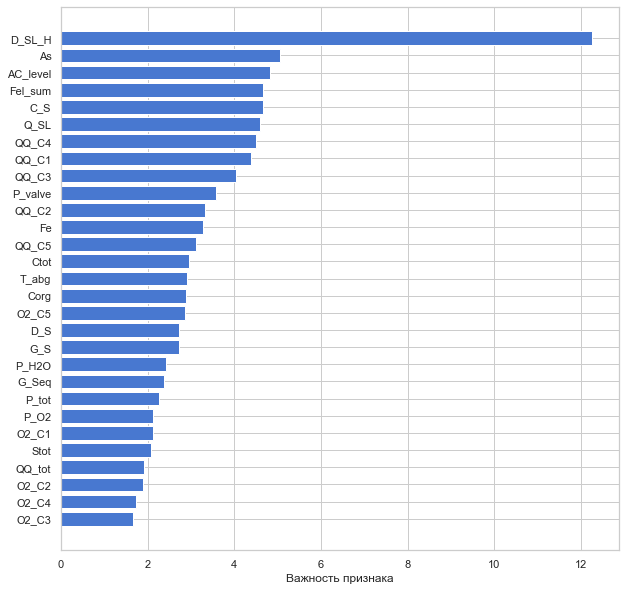

In [195]:
sorted_feature_importance = model.feature_importances_.argsort()

plt.figure(figsize=(10,10))
plt.barh(X.columns[sorted_feature_importance], model.feature_importances_[sorted_feature_importance])
plt.xlabel("Важность признака")
plt.show();

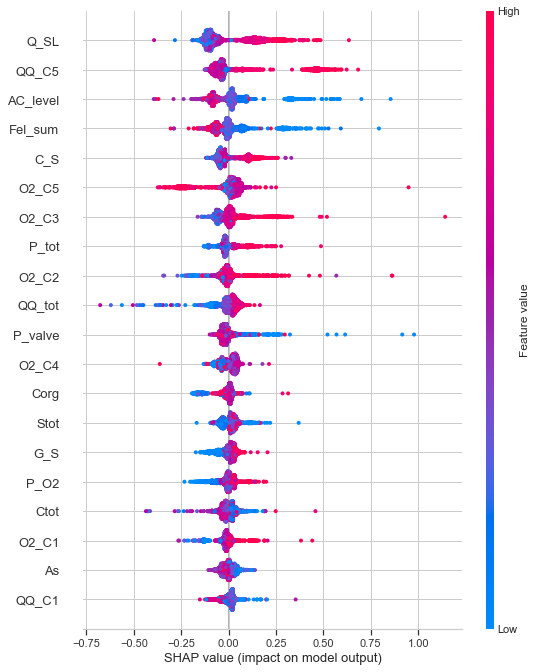

In [196]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names = X.columns[sorted_feature_importance])

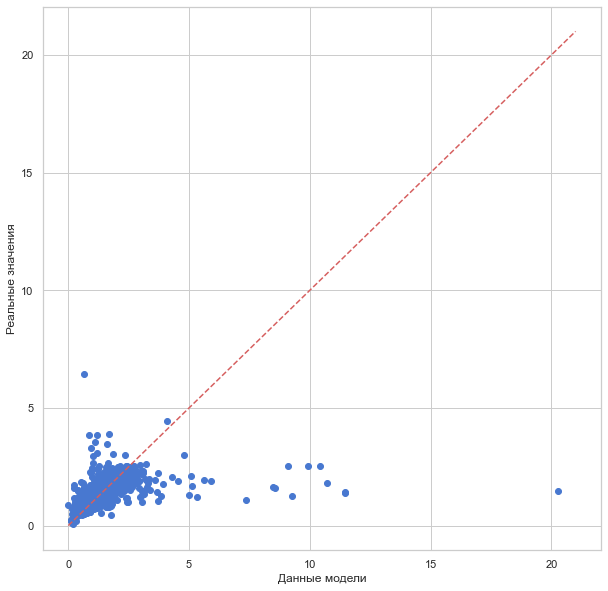

In [205]:
import math

plt.figure(figsize=(10,10))
plt.scatter(y_test.values, pred)

scale = math.ceil(max(y_test.values.max(), pred.max()))
plt.plot([0, scale], [0, scale], 'r--')

plt.xlabel("Данные модели")
plt.ylabel("Реальные значения")

plt.show();

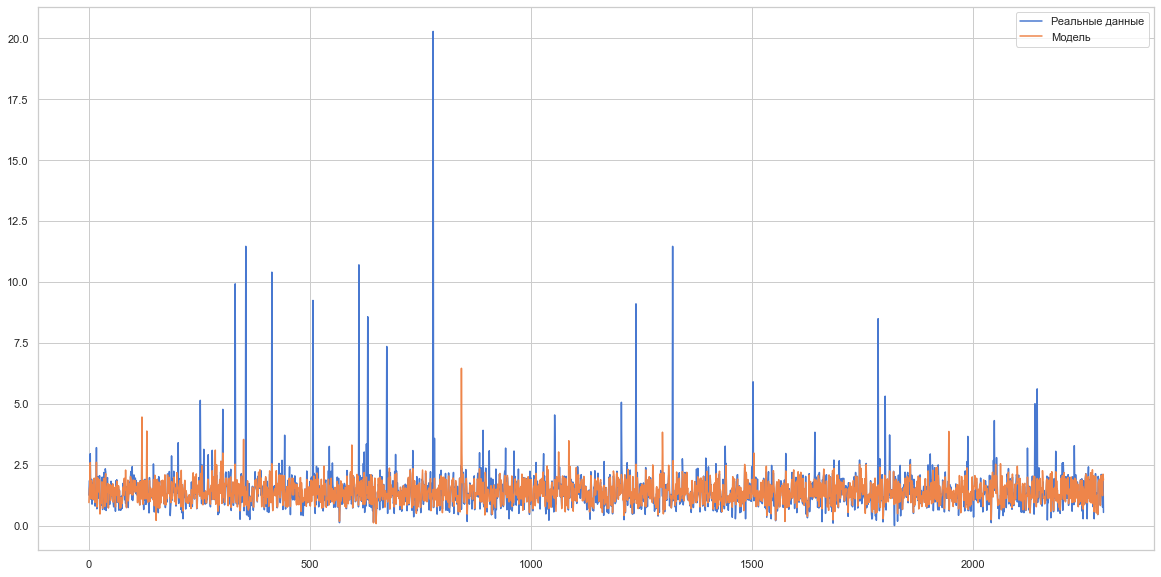

In [198]:
plt.figure(figsize=(20,10))

plt.plot(y_test.values, label='Реальные данные')
plt.plot(pred, label='Модель')

plt.legend()
plt.show();

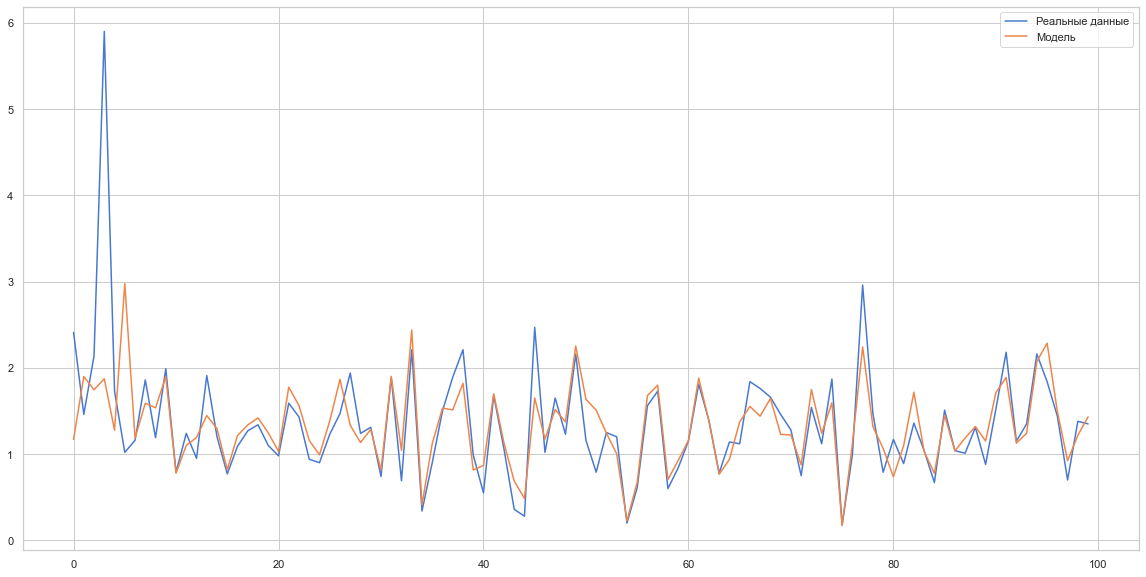

In [199]:
plt.figure(figsize=(20,10))

plt.plot(y_test.values[1500:1600], label='Реальные данные')
plt.plot(pred[1500:1600], label='Модель')

plt.legend()
plt.show();